# Importing Libraries
We are mainly using openCV, keras, tensorflow libraries for this research. The purpose of this research is to find out the best performing model than can classify shoplifiting from videos and provide alert signals to the shop incharges to prevent this outlaw. We are going to try our best to find the best model and parameter that will show case the best performance.  

### The models that we will try out are
- VGG16 (224 x 224 x 3)
- VGG19 (224 x 224 x 3)
- ResNet50 (224 x 224 x 3)
- DenseNet121 (224 x 224 x 3)
- InceptionV3 (299 x 299 x 3)

The first task is to import the libraries - 

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as p
import imutils

from scipy import ndimage
from moviepy.editor import *
from PIL import Image
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import ResNet50, VGG16, VGG19, DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, ZeroPadding2D, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils.vis_utils import plot_model, model_to_dot


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn import preprocessing

In [2]:
outputmodelpath = r'model/'
outputbinarizerpath = r'model/'

DATA_DIR = './data'
CATEGORIES = ['Shoplifting', 'Normal_Activity']
data = []
labels = []
global train_x, test_x, train_y, test_y, train_gen, validation_gen, lb

We are declaring some paths to save our **model** and **binarizer**. Now, we will start our preprocessing. The first step is to load the **images correctly**.


# Preprocessing

In [3]:
def preprocess_data_to_images():
    pathOut = "./sample"
    count = 0
    counter = 1

    frames = []

    for c in CATEGORIES:
        path = os.path.join(DATA_DIR, c)
        class_num = CATEGORIES.index(c)

        for vid in tqdm(os.listdir(path)):
            try:
                vid = os.path.join(path, vid)
                cap = cv2.VideoCapture(vid)
                count = 0
                counter += 1
                success = True
                while success:
                    success,image = cap.read()
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            #         print('read a new frame:',success)
                    if count%30 == 0 :
                        frames.append([image, class_num])
                        cv2.imwrite(pathOut + 'frame%d.jpg'%count,image)
                    count+=1
            except Exception as e:
                pass

    print(count, " frames extracted")
    # frames = np.array(frames)
    # print("data shape =\t", frames.shape)

In [4]:
def preprocess_data(IMG_SIZE = 224):
    for c in CATEGORIES:
        path = os.path.join(DATA_DIR, c)
        class_num = CATEGORIES.index(c)

        for img in  tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([img_resized, class_num])
                labels.append(CATEGORIES[class_num])
            except Exception as e:
                pass
    print("--------------------------")
    print("Images loaded successfully!")
    print(f"Found {len(data)} images and {len(labels)} labels from {len(CATEGORIES)} Categories")
    #data = np.array(data)
#     np.random.shuffle(data)

# Visualizing the images for visual assessment of the data

In [5]:
def plot_image_data():
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(data[i][0])
        plt.xlabel(CATEGORIES[data[i][1]])
    plt.show()

# Splitting the Data into train and test splits

In [6]:
def split_data():
    global lb
    
    lb = preprocessing.LabelBinarizer()

    x = []
    y = []

    for i in range(len(data)):
        x.append(data[i][0])
        y.append(data[i][1])

    x = np.array(x)
    y = np.array(y)

    y = lb.fit_transform(y)
    
    global train_x, test_x, train_y, test_y
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)

# Augmenting the data for better training

In [7]:
def augment_data():
    global train_gen, validation_gen
    
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
    train_gen = train_datagen.flow(train_x, train_y, batch_size=32)

    validation_datagen = ImageDataGenerator(rescale=1.0/255)
    validation_gen = validation_datagen.flow(test_x, test_y)
    

def augment_data_resnet():
    global train_gen, validation_gen

    train_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)
    validation_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)
    
    train_gen = train_datagen.flow(train_x, train_y, batch_size=32)
    validation_gen = validation_datagen.flow(test_x, test_y)

# Model Creation

## VGG16

In [8]:
def model_vgg16():
    baseModel = VGG16(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))
    
    headModel = baseModel.output
    headModel = MaxPooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
        
    return model

## VGG19

In [9]:
def model_vgg19():
    baseModel = VGG19(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))
    headModel = baseModel.output
    headModel = MaxPooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
    
    return model

## ResNet50

In [10]:
def model_resnet50():
    baseModel = ResNet50(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))
    
    headModel = baseModel.output
    headModel = MaxPooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.75)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
    
    return model

# DenseNet121

In [11]:
def model_densenet121():
    baseModel = DenseNet121(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))
    headModel = baseModel.output
    headModel = MaxPooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(100, activation="relu")(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = Dense(20, activation="relu")(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
    
    return model

## InceptionV3

In [12]:
def model_inceptionV3():
    baseModel = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299,299,3)), pooling='avg')
    
    headModel = baseModel.output
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(2048, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
#     headModel = Dense(1000, activation="relu")(headModel)
#     headModel = Dropout(0.2)(headModel)
#     headModel = Dense(200, activation="relu")(headModel)
#     headModel = Dropout(0.2)(headModel)
#     headModel = Dense(40, activation="relu")(headModel)
#     headModel = Dropout(0.2)(headModel)
#     headModel = Dense(1, activation="sigmoid")(headModel)
#     model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
        
    return model

## Custom

In [13]:
def model_custom():
    model = Sequential()
    model.add(Conv2D(100, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
    model.add(Conv2D(100, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(50, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(25, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(25, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    
    return model

# Train the model

In [14]:
def train_model(model, epch = 20, opt = SGD(learning_rate=0.01), ls = "binary_crossentropy"):
    
    model.compile(loss=ls, optimizer=opt, metrics=["accuracy"])
    
    history = model.fit_generator(
        train_gen,
        steps_per_epoch = len(train_x)//32,
        validation_data = validation_gen,
        validation_steps = len(test_x)//32,
        epochs = epch
    )
    
    return history

# Test the model

In [15]:
def test_model(model):
    score = model.evaluate(test_x, test_y, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

# Saving the Model and the Binarizer

In [16]:
def save_model(model):
    model.save(outputmodelpath)
    lbinarizer = open(outputbinarizerpath)
    lbinarizer.write(p.dump(lb))
    lbinarizer.close()


def save_history_as_pickle(history):
    with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


def save_history_as_json(history):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    hist_json_file = 'history/model.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)


def save_history_as_json(history):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    hist_csv_file = 'history/model.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

# Plotting the Loss and Accuracy

In [17]:
def plot_data(history, epoch):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    xc = range(epoch)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print(plt.style.available) # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

# Write your code from here

In [18]:
data = []
labels = []
preprocess_data(299)

100%|██████████████████████████████████████████████████████████████████████████████| 1663/1663 [00:26<00:00, 61.68it/s]

--------------------------
Images loaded successfully!
Found 2553 images and 2553 labels from 2 Categories


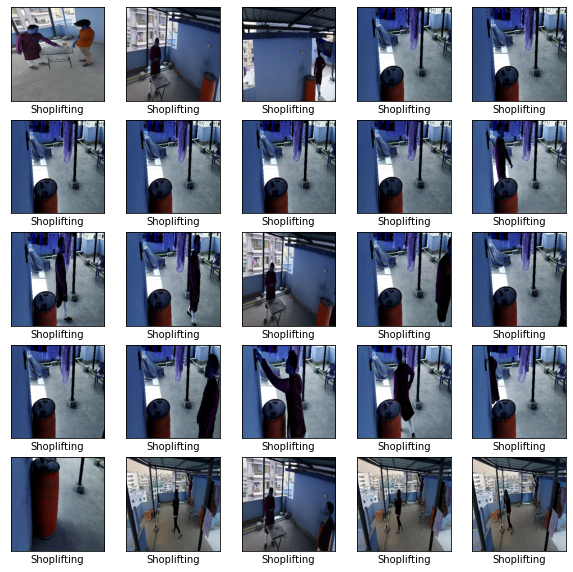

In [20]:
plot_image_data()

In [20]:
split_data()

In [21]:
augment_data()

In [22]:
# model = model_vgg16() #sgd, binary_crossentropy
# model = model_vgg19() #sgd, binary_crossentropy
# augment_data_resnet()
# model = model_resnet50() #sgd1, binary_crossentropy
# model = model_densenet121() #adam, categorical_crossentropy
model = model_inceptionV3() #rms, hinge / 65% adam1, hinge, relu->dropout .75->sigmoid
# model = model_custom()
# print(model.summary())

# summarize filter shapes
# for layer in model.layers:
#     # check for convolutional layer
#     print(layer.name)
#     if 'conv' not in layer.name:
#         continue

In [24]:
opt_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
opt_adam1= Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.1, amsgrad=True)
opt_sgd  = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
opt_sgd1 = SGD(learning_rate=0.01, momentum=0.5, nesterov=True)
opt_rms  = RMSprop(learning_rate=0.1, rho=0.9, momentum=0.9, epsilon=0.1, centered=True)

In [ ]:
history = train_model(model, 20, opt_rms)
# history = train_model(model, 20, opt_sgd1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
63/63 [==============================] - 193s 3s/step - loss: 101834416.0000 - accuracy: 0.6254 - val_loss: 0.6479 - val_accuracy: 0.6500
Epoch 2/20
63/63 [==============================] - 204s 3s/step - loss: 19071606.0000 - accuracy: 0.6498 - val_loss: 0.6489 - val_accuracy: 0.6542
Epoch 3/20
63/63 [==============================] - 199s 3s/step - loss: 0.6606 - accuracy: 0.6507 - val_loss: 0.6587 - val_accuracy: 0.6542
Epoch 4/20
63/63 [==============================] - 199s 3s/step - loss: 2272476.7500 - accuracy: 0.6502 - val_loss: 0.6554 - val_accuracy: 0.6458
Epoch 5/20
63/63 [==============================] - 198s 3s/step - loss: 258504.0469 - accuracy: 0.6498 - val_loss: 0.6543 - val_accuracy: 0.6521
Epoch 6/20
63/63 [==============================] - 198s 3s/step - loss: 1375.6035 - accuracy: 0.6537 - val_loss: 0.6479 - val_accuracy: 0.6500
Epoch 7/20
26/63 [===========>..................]

In [123]:
test_model(model)

Test loss: 0.6531103253364563
Test accuracy: 0.6516634225845337


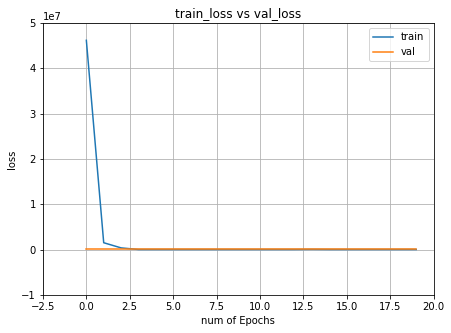

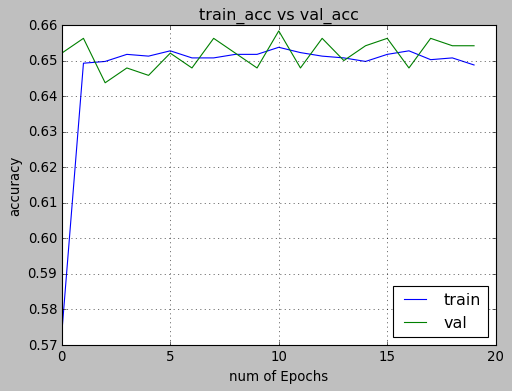

In [124]:
plot_data(history, 20)

In [125]:
model.save(outputmodelpath+"InceptionV3/")

lbinarizer = open(r"E:\Project\Python\Jupyter\Thesis\Fully Working\model\InceptionV3\binarizer.pkl", "wb")
p.dump(lb, lbinarizer)
lbinarizer.close()
                  
# with open('/trainHistoryDict', 'wb') as file_pi:
#         p.dump(history.history, file_pi)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/resnet50InceptionV3/assets


In [76]:
print(history)

In [114]:
lbinarizer = open(r"E:\Project\Python\Jupyter\Thesis\Fully Working\model\binarizer.pkl", "wb")
p.dump(lb, lbinarizer)
lbinarizer.close()

In [58]:
from keras.models import load_model
outputmodelpath = r'model/resnet50'

path = r"model/resnet50/"
model = load_model(path)

score = model.evaluate(train_x, train_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 7.764366216633789e-08
Test accuracy: 0.6552399396896362


In [126]:
model = model_inceptionV3()

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False)